In [353]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
import torch

X, y = make_circles(n_samples=5000, noise=0.07, random_state=42)



In [354]:
circles = pd.DataFrame({"X1": X[:,0],
                        "X2": X[:,1],
                        "label": y})
circles

,X1,X2,label
0,-0.673669,-0.529326,0
1,0.800889,0.071657,1
2,0.755721,0.315145,1
3,-0.896196,0.515012,0
4,-0.121177,0.922567,0
...,...,...,...
4995,0.251906,-0.726875,1
4996,0.407688,0.956474,0
4997,0.118307,0.915230,1
4998,-0.716577,-0.008217,1


In [355]:
circles.label.value_counts()

label
0    2500
1    2500
Name: count, dtype: int64

In [356]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


In [357]:
def circles_plot(X=X, y=y, model= None):
        if model is not None:
            plt.figure(figsize=(16, 8))
            plt.subplot(1, 2, 1)
            plt.title("Train")
            plot_decision_boundary(model, X, y)
        else:
            plt.figure(figsize=(12,12))
            plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlBu)


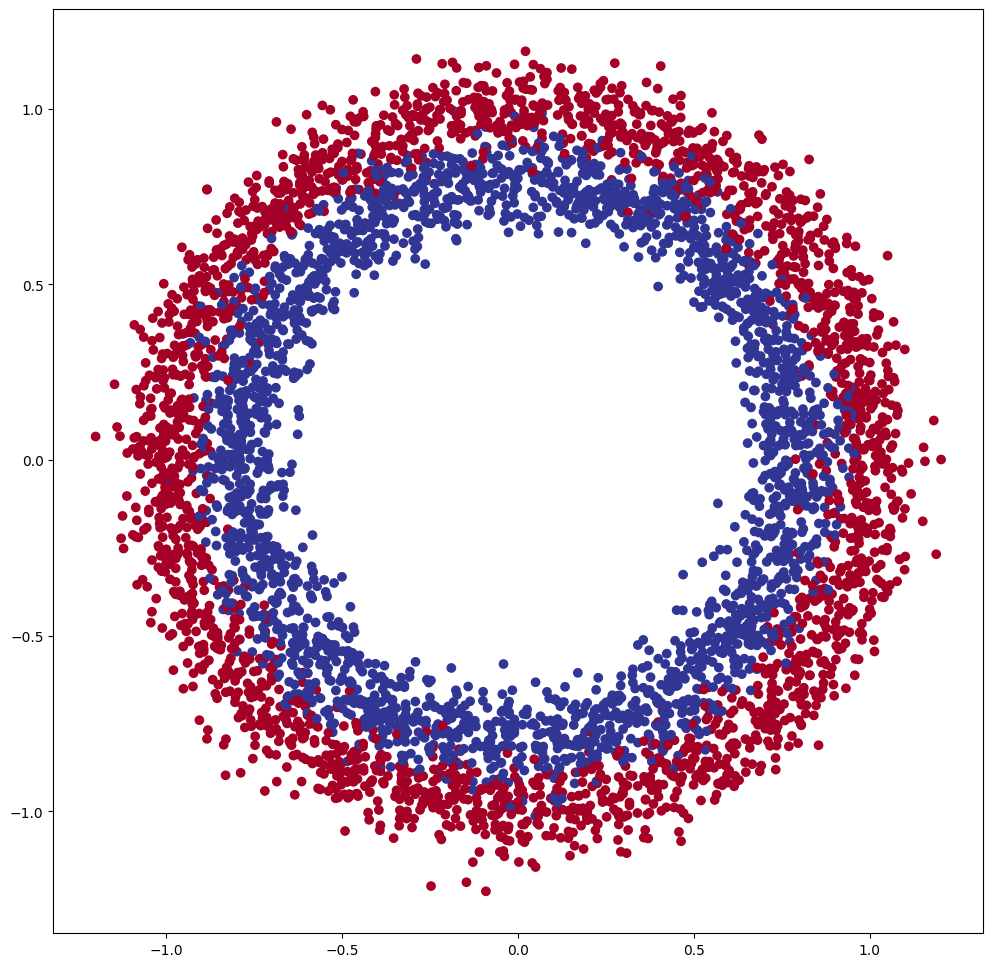

In [358]:
circles_plot()

In [359]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)


X, y

(tensor([[-0.6737, -0.5293],
         [ 0.8009,  0.0717],
         [ 0.7557,  0.3151],
         ...,
         [ 0.1183,  0.9152],
         [-0.7166, -0.0082],
         [-0.6079,  0.8596]]),
 tensor([0., 1., 1.,  ..., 1., 1., 0.]))

In [360]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42, test_size=0.2)

len(X_train), len(y_train), len(X_test), len(y_test), 

(4000, 4000, 1000, 1000)

In [361]:
from torch import nn

class LinearClassifier(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer1 = nn.Linear(in_features=2, out_features=5,)
        self.layer2 = nn.Linear(in_features=5, out_features=2)

    def forward(self, x):
        return self.layer2(self.layer1(x))
    
model_0 = LinearClassifier()
model_0

LinearClassifier(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=2, bias=True)
)

In [362]:
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [363]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.05)

In [364]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100 
    return acc

In [365]:
%%time

torch.manual_seed(42)

epochs = 200

train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    model_0.train()

    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_pred)

    acc = accuracy_fn(y_train, y_pred)


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(y_test, test_pred)
        test_acc = accuracy_fn(y_test, test_pred)

        epoch_count.append(epoch)
        train_loss_values.append(loss.detach().numpy())
        test_loss_values.append(test_loss.detach().numpy())

    if epoch % 10 == 0:
        print(f"epoch: {epoch}    |    train loss: {loss} , train accuracy: {acc}    |    test loss: {test_loss} , test accuracy: {test_acc}")

epoch: 0    |    train loss: 0.5290971398353577 , train accuracy: 50.7    |    test loss: 0.7250873446464539 , test accuracy: 49.4
epoch: 10    |    train loss: 0.47866660356521606 , train accuracy: 50.625    |    test loss: 0.7270873188972473 , test accuracy: 49.4
epoch: 20    |    train loss: 0.4320223927497864 , train accuracy: 50.675000000000004    |    test loss: 0.7290873527526855 , test accuracy: 49.4
epoch: 30    |    train loss: 0.3897065818309784 , train accuracy: 50.6    |    test loss: 0.731087327003479 , test accuracy: 49.2
epoch: 40    |    train loss: 0.3520108759403229 , train accuracy: 50.55    |    test loss: 0.7330873608589172 , test accuracy: 49.1
epoch: 50    |    train loss: 0.31895387172698975 , train accuracy: 50.375    |    test loss: 0.7350873351097107 , test accuracy: 49.3
epoch: 60    |    train loss: 0.2903064489364624 , train accuracy: 50.375    |    test loss: 0.7370873689651489 , test accuracy: 49.3
epoch: 70    |    train loss: 0.2656789720058441 , trai

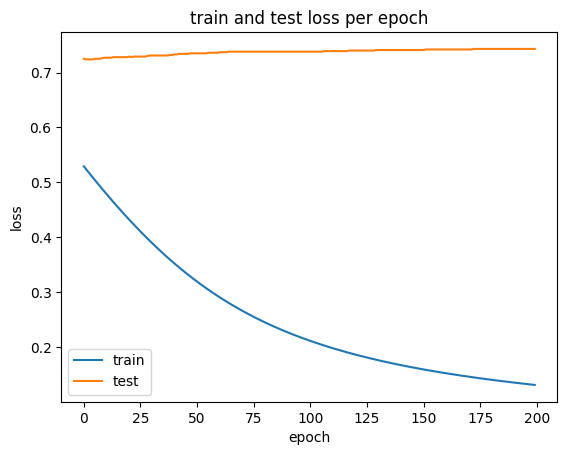

In [366]:
plt.plot(epoch_count, train_loss_values, label="train")
plt.plot(epoch_count, test_loss_values, label="test")

plt.title("train and test loss per epoch")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()

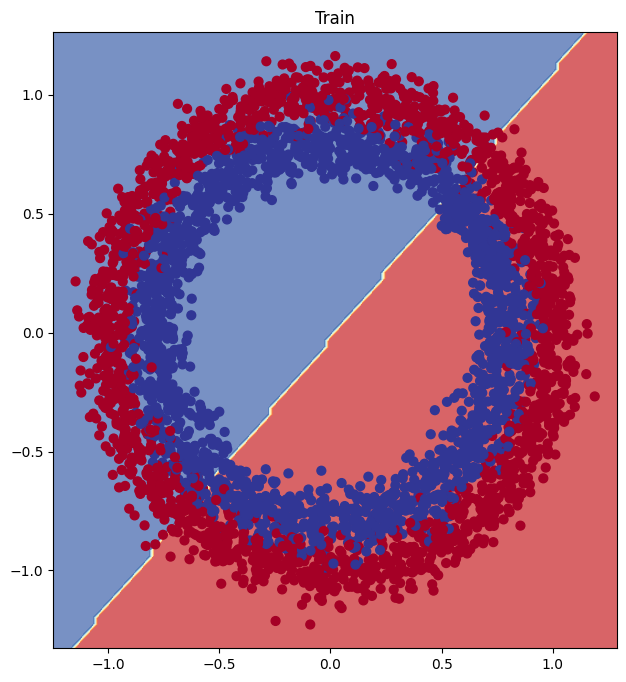

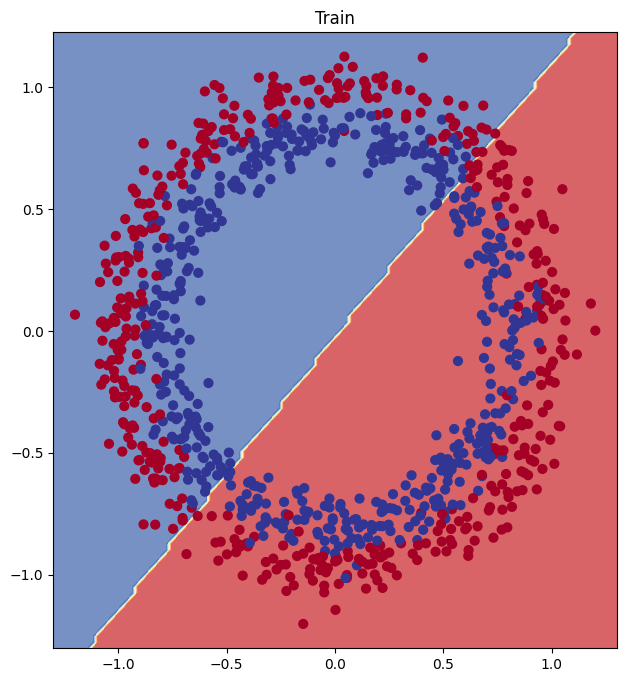

In [367]:
circles_plot(X_train, y_train, model_0)
circles_plot(X_test, y_test, model_0)

In [368]:
class NoneLinearClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_1 = NoneLinearClassifier()
print(model_1)

NoneLinearClassifier(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [369]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_1.parameters(),
                            lr=0.1)

In [370]:
torch.manual_seed(42)
epochs = 3000

train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):

    model_1.train()
    
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)

    
    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_1.eval()
    with torch.inference_mode():

      test_logits = model_1(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits))

      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

      epoch_count.append(epoch)
      train_loss_values.append(loss.detach().numpy())
      test_loss_values.append(test_loss.detach().numpy())

    if epoch % 10 == 0:
               print(f"epoch: {epoch}    |    train loss: {loss} , train accuracy: {acc}    |    test loss: {test_loss} , test accuracy: {test_acc}")

epoch: 0    |    train loss: 0.6930935382843018 , train accuracy: 49.45    |    test loss: 0.6922274231910706 , test accuracy: 52.900000000000006
epoch: 10    |    train loss: 0.6925484538078308 , train accuracy: 57.95    |    test loss: 0.6921573281288147 , test accuracy: 63.800000000000004
epoch: 20    |    train loss: 0.6921893358230591 , train accuracy: 56.15    |    test loss: 0.6921657919883728 , test accuracy: 54.800000000000004
epoch: 30    |    train loss: 0.6919481158256531 , train accuracy: 52.225    |    test loss: 0.6922017931938171 , test accuracy: 50.5
epoch: 40    |    train loss: 0.6917556524276733 , train accuracy: 52.1    |    test loss: 0.6922188997268677 , test accuracy: 50.0
epoch: 50    |    train loss: 0.6915876865386963 , train accuracy: 51.849999999999994    |    test loss: 0.692213237285614 , test accuracy: 48.9
epoch: 60    |    train loss: 0.6914306282997131 , train accuracy: 51.6    |    test loss: 0.6921823024749756 , test accuracy: 48.5
epoch: 70    |   

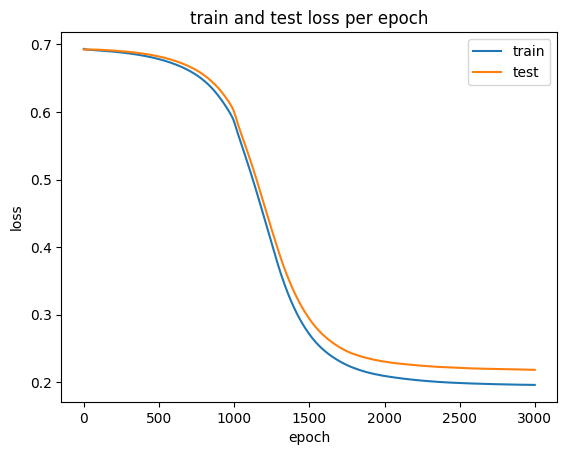

In [371]:
plt.plot(epoch_count, train_loss_values, label="train")
plt.plot(epoch_count, test_loss_values, label="test")

plt.title("train and test loss per epoch")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()

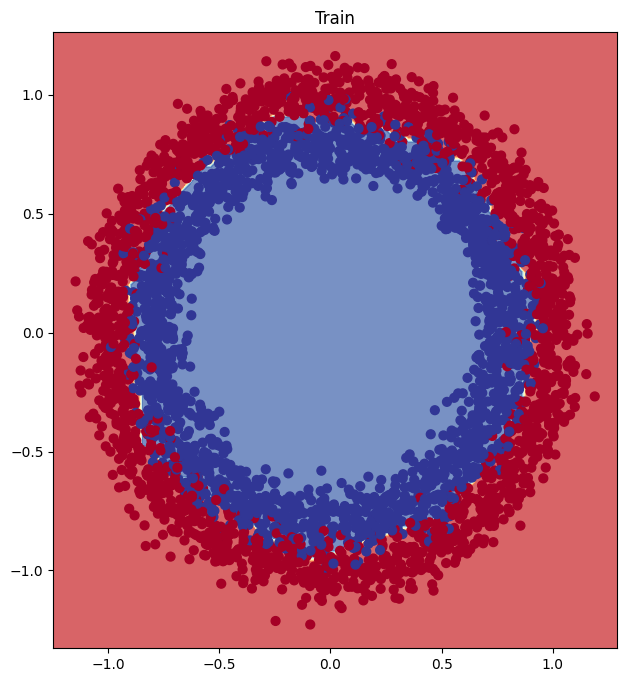

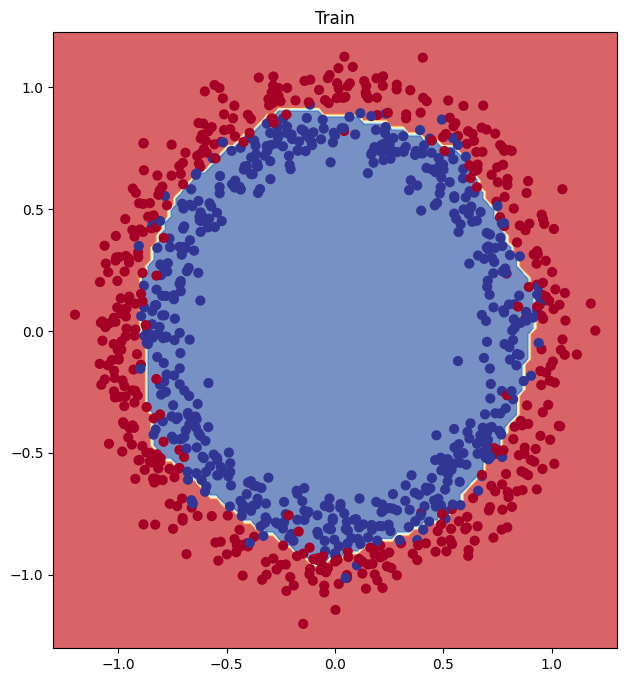

In [372]:
circles_plot(X_train, y_train, model_1)
circles_plot(X_test, y_test, model_1)